# B2B SALES AND CUSTOMER INSIGHT ANALYSIS

Project Tasks:
1. Data Acquisition
* Secure transactional datasets with comprehensive sales and payment information. 
2. Data Pre-processing:
* Clean and standardize data to ensure quality and uniformity
* Address missing values and remove duplicates to facilitate accurate analysis.
3. Sales Trend Analysis:
* Investigate patterns and trends in sales data over time 
4. Payment Behavior Analysis:
* Evaluate the impact of B2B (Business to Business) transactions on order value
* Assess the influence of promotions on purchasing trends.
5. Customer Segmentation:
* Geographical Segmentation
* Behavioral Segmentation
6. Customer Lifetime Value(CLV) Analysis
* Calculate the lifetime value of each customer segment to prioritize marketing efforts and forecast future revenue. This analysis will help in identifying the most valuable customers and understanding their long-term value to the business.
7. Market Basket Analysis
* Explore the combinations of products that are commonly purchased together to identify opportunities for cross-selling and up-selling. This analysis is useful for optimizing product placement, promotional strategies, and inventory stocking. 
8. Results
* Compile and present the analysis findings in a clear and actionable format. Highlight key insights that can drive business strategy and operational improvements, and offer data- driven recommendations to enhance B2B sales performance and customer purchasing behavior.

In [1]:
pip install pyfpgrowth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pyfpgrowth: filename=pyfpgrowth-1.0-py2.py3-none-any.whl size=5488 sha256=aa6a725875b88e6f3ae11b8b806eb209614117abb17fe88f174a51677bf81732
  Stored in directory: /root/.cache/pip/wheels/09/fc/dc/afff211038bfc745722d8d7e846e854e5791968b22c570a530
Successfully built pyfpgrowth
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyfpgrowth
import numpy as np


# 1. Data Acquisition

In [3]:
file_path = '/kaggle/input/unlock-profits-with-e-commerce-sales-data/Amazon Sale Report.csv' 
data = pd.read_csv(file_path) 
print(data.head()) 
print(data.info())

/tmp/ipykernel_20/1218380060.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


   index             Order ID      Date                        Status  \
0      0  405-8078784-5731545  04-30-22                     Cancelled   
1      1  171-9198151-1101146  04-30-22  Shipped - Delivered to Buyer   
2      2  404-0687676-7273146  04-30-22                       Shipped   
3      3  403-9615377-8133951  04-30-22                     Cancelled   
4      4  407-1069790-7240320  04-30-22                       Shipped   

  Fulfilment Sales Channel  ship-service-level    Style              SKU  \
0   Merchant      Amazon.in           Standard   SET389   SET389-KR-NP-S   
1   Merchant      Amazon.in           Standard  JNE3781  JNE3781-KR-XXXL   
2     Amazon      Amazon.in          Expedited  JNE3371    JNE3371-KR-XL   
3   Merchant      Amazon.in           Standard    J0341       J0341-DR-L   
4     Amazon      Amazon.in          Expedited  JNE3671  JNE3671-TU-XXXL   

        Category  ... currency  Amount    ship-city   ship-state  \
0            Set  ...      INR  647.

# 2. DATA PRE-PROCESSING

## 2. 1. DEALING WITH MIXED-TYPES

Look's like 'Unnamed: 22' column has mixed types. Let's deep dive into this column

In [4]:
# Displaying the unique values in 'Unnamed: 22'
unique_values_unnamed_22 = data['Unnamed: 22'].unique() 
num_unique_values_unnamed_22 = len(unique_values_unnamed_22)
# Printing the first few entries to get a sense of what kind of data it contains
sample_values_unnamed_22 = unique_values_unnamed_22[:5]
print(f"Unique values in 'Unnamed: 22':\n{unique_values_unnamed_22}") 
print(f"Number of unique values in 'Unnamed: 22': {num_unique_values_unnamed_22}")
print(f"Sample values from 'Unnamed: 22':\ n{sample_values_unnamed_22}")

Unique values in 'Unnamed: 22':
[nan False]
Number of unique values in 'Unnamed: 22': 2
Sample values from 'Unnamed: 22':\ n[nan False]


The 'Unnamed: 22' column contains only two unique values: NaN and False. Given that the other values are False, we could convert NaNs to True to make it a proper boolean column. However, since the column is unnamed and does not have a clear description or purpose, it likely won't provide any valuable insight into our analysis. **With this in mind, it is most practical to remove this column from our dataset.**

In [5]:
data.drop(columns=['Unnamed: 22'], inplace=True)
print(data.columns)

Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city',
       'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids',
       'B2B', 'fulfilled-by'],
      dtype='object')


## 2.2. STANDARDIZING COLUMN NAMES

In [6]:
data.columns = [col.strip().replace("-", "_").lower() for col in data.columns]

## 2.3. Handling Missing Values

In [7]:
print(data.isnull().sum())

index                     0
order id                  0
date                      0
status                    0
fulfilment                0
sales channel             0
ship_service_level        0
style                     0
sku                       0
category                  0
size                      0
asin                      0
courier status         6872
qty                       0
currency               7795
amount                 7795
ship_city                33
ship_state               33
ship_postal_code         33
ship_country             33
promotion_ids         49153
b2b                       0
fulfilled_by          89698
dtype: int64


When handling missing values in a dataset, we aim to maximize the retention of data to preserve potential insights, while ensuring that the integrity and quality of the analysis are not compromised. Directly removing rows or columns with missing values can lead to a significant loss of information, especially if the dataset is not large or if the missingness is not random. Instead, we explore each column with missing values to determine the best course of action

In [8]:
print(data['courier status'].value_counts(dropna=False))

courier status
Shipped      109487
NaN            6872
Unshipped      6681
Cancelled      5935
Name: count, dtype: int64


The 'courier status' column indicates the status of the shipment. The options 'Shipped', 'Unshipped', and 'Cancelled' represent clear stages in the shipping process. If there are no other statuses besides these three and NaN, it suggests that the missing values (NaN) could potentially represent a status that wasn't recorded or is unknown at the time of data collection.

In [9]:
data['courier status'].fillna('Unknown', inplace=True)
print(data.groupby('sales channel')
['currency'].value_counts(dropna=False))

sales channel  currency
Amazon.in      INR         121180
               NaN           7671
Non-Amazon     NaN            124
Name: count, dtype: int64


For the 'Amazon.in' sales channel, the currency is overwhelmingly INR except for some missing values. We can confidently impute these missing values with 'INR'. For the 'Non-Amazon' channel, the lack of any currency information suggests that we should mark these as 'Unknown'.

In [10]:
# Imputing missing 'currency' for 'Amazon.in' sales channel with 'INR'
data.loc[(data['sales channel'] == 'Amazon.in') & (data['currency'].isnull()), 'currency'] = 'INR'
# For the 'Non-Amazon' sales channel, we mark the currency as 'Unknown'
data.loc[(data['sales channel'] == 'Non-Amazon') & (data['currency'].isnull()), 'currency'] = 'Unknown'
print(data.groupby('sales channel')
['currency'].value_counts(dropna=False))

sales channel  currency
Amazon.in      INR         128851
Non-Amazon     Unknown        124
Name: count, dtype: int64


In [11]:
# Investigating if missing shipping details are from the same rows
missing_shipping_info = data[data['ship_city'].isnull() &
data['ship_state'].isnull() &
                             data['ship_postal_code'].isnull() & data['ship_country'].isnull()]
print(missing_shipping_info)

         index             order id      date                        status  \
1871      1871  404-0566904-4825137  04-29-22                       Shipped   
1872      1872  404-0566904-4825137  04-29-22                       Shipped   
8752      8752  406-4003386-8768363  04-25-22                       Shipped   
11215    11215  402-0107720-7057168  04-23-22                       Shipped   
13252    13252  407-4532637-8415521  04-22-22                     Cancelled   
15688    15688  404-9229894-8608305  04-21-22                       Shipped   
16787    16787  402-4919636-4333150  04-20-22  Shipped - Delivered to Buyer   
18351    18351  405-4927647-8064368  04-19-22                       Shipped   
22930    22930  402-8628677-0457954  04-16-22  Shipped - Returned to Seller   
24986    24986  406-4079063-8291520  04-15-22                     Cancelled   
30379    30379  404-7506843-7913132  04-12-22  Shipped - Delivered to Buyer   
37963    37963  407-3064376-9158743  04-08-22       

Upon investigating the rows with missing shipping details, we found that other pieces of information in these rows are complete. This suggests a problem with data entry or collection for shipping information specifically. Given that these records contain valuable information otherwise, and the missing shipping details represent a minor portion of the data, it is preferable to retain these rows for analysis. We can mark the missing shipping details as 'Unknown' to preserve the integrity of the dataset without making unjustified assumptions about the missing data.

In [12]:
# Marking missing shipping details as 'Unknown'
shipping_columns = ['ship_city', 'ship_state', 'ship_postal_code','ship_country']
for column in shipping_columns:
    data[column].fillna('Unknown', inplace=True)
print(data[shipping_columns].isnull().sum())

ship_city           0
ship_state          0
ship_postal_code    0
ship_country        0
dtype: int64


In [13]:
# Looks like 'promotion_ids' means there is no promotion applied in this dataframe, let's fill NaN with 'No Promotion' 
data['promotion_ids'].fillna('No Promotion', inplace=True)
# We can say that if NaN are not 'Easy Ship' we can fiil it with normal ship
data['fulfilled_by'].fillna('Normal Ship', inplace=True)
print(data[['promotion_ids', 'fulfilled_by']].isnull().sum())

promotion_ids    0
fulfilled_by     0
dtype: int64


In [14]:
print(data['ship_postal_code'].dropna().head())

0    400081.0
1    560085.0
2    410210.0
3    605008.0
4    600073.0
Name: ship_postal_code, dtype: object


In [15]:
# Converting 'ship_postal_code' to string while preserving leading zeros
data['ship_postal_code'] = data['ship_postal_code'].apply(lambda x: '{:0>5}'.format(x) if pd.notnull(x) else x)
print(data['ship_postal_code'].head())

0    400081.0
1    560085.0
2    410210.0
3    605008.0
4    600073.0
Name: ship_postal_code, dtype: object


In [16]:
# Converting 'Date' from object to datetime
data['date'] = pd.to_datetime(data['date'])

/tmp/ipykernel_20/2096752236.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'])


## 2.4. CATEGORICAL COLUMNS

In [17]:
categorical_columns = ['status', 'fulfilment', 'sales channel',
'ship_service_level',
'currency',
'promotion_ids',
'style', 'category', 'size', 'courier status',
'ship_city', 'ship_state', 'ship_country',
'fulfilled_by']
for column in categorical_columns:
    data[column] = data[column].astype('category')
print(data.dtypes)

index                          int64
order id                      object
date                  datetime64[ns]
status                      category
fulfilment                  category
sales channel               category
ship_service_level          category
style                       category
sku                           object
category                    category
size                        category
asin                          object
courier status              category
qty                            int64
currency                    category
amount                       float64
ship_city                   category
ship_state                  category
ship_postal_code              object
ship_country                category
promotion_ids               category
b2b                             bool
fulfilled_by                category
dtype: object


## 2.5. HANDLING DUPLICATES

In [18]:
data.drop_duplicates(inplace=True)
data.to_csv('Cleaned_Amazon_Sale_Report.csv', index=False)

# 3. SALES TREND ANALYSIS

## 3.1. SALES OVER TIME

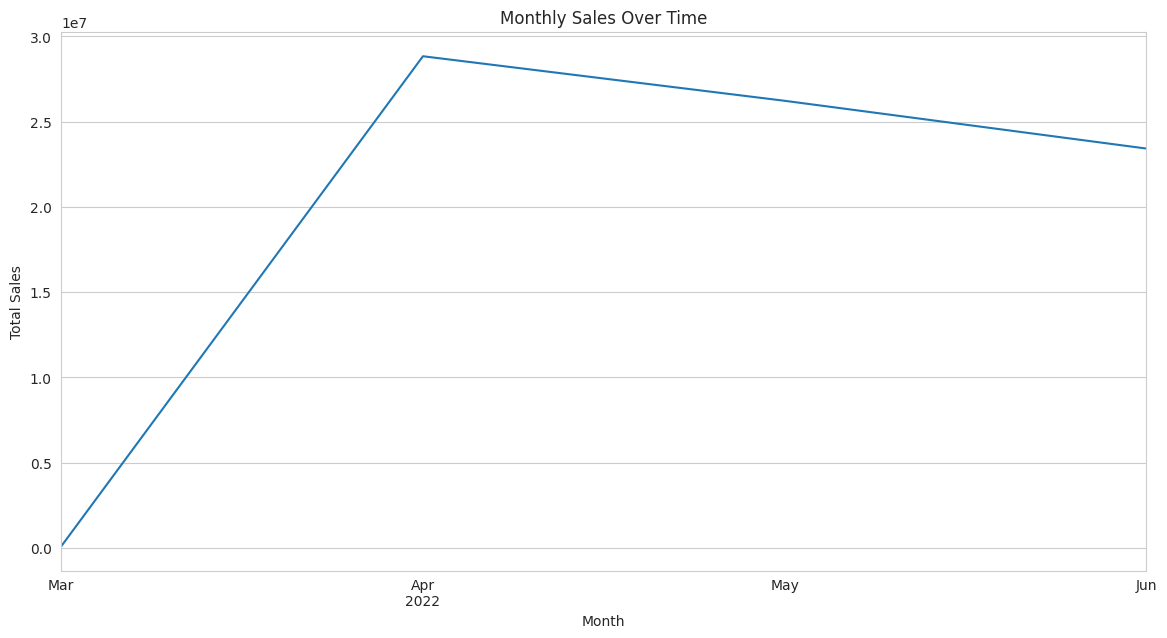

In [19]:
sns.set_style('whitegrid')
# Resample to monthly sales and plot
monthly_sales = data.resample('M', on='date')['amount'].sum() 
plt.figure(figsize=(14, 7))
monthly_sales.plot(title='Monthly Sales Over Time') 
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

The sales trend chart displayed indicates **a sharp increase in sales from March to April**, followed by **a peak in April**. After reaching this peak, there's a **noticeable decline through May and into June**. This pattern could suggest a few different scenarios:
* The peak in April might be due to seasonal factors, specific promotions, or external events that drove a higher volume of sales.
* The subsequent decrease could indicate the end of a sales promotion, a seasonal downtrend, or the saturation of a particular market segment following a period of high demand.

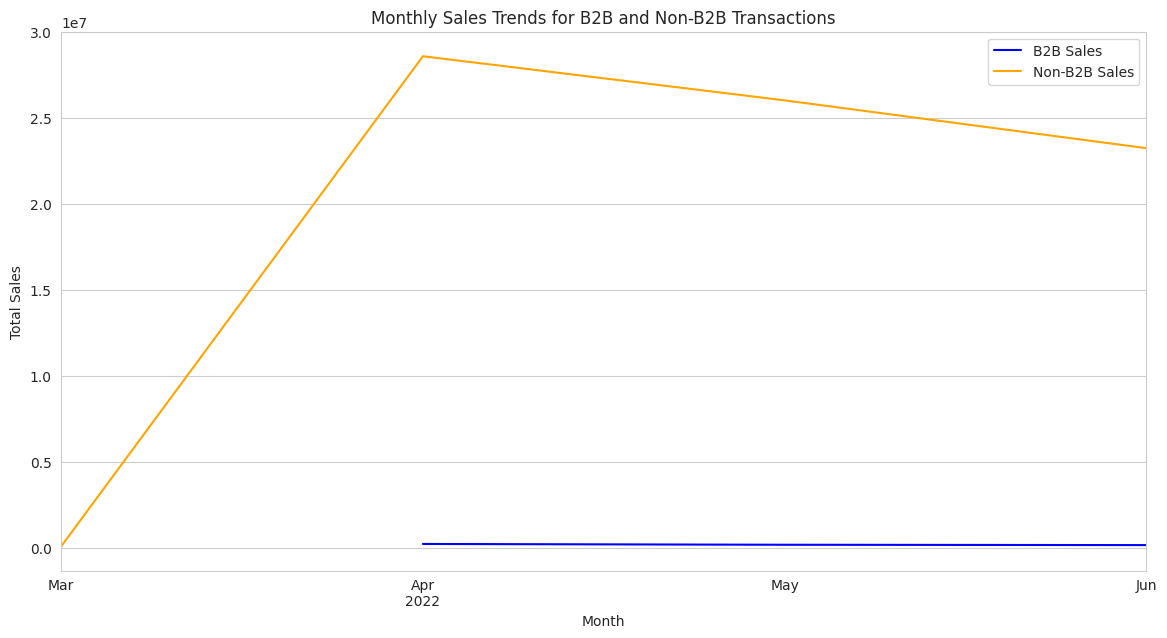

In [20]:
monthly_sales_b2b = data[data['b2b']].resample('M', on='date')['amount'].sum()
monthly_sales_non_b2b = data[~data['b2b']].resample('M', on='date')['amount'].sum()
# Plotting the sales trends over time for B2B transactions
plt.figure(figsize=(14, 7))
monthly_sales_b2b.plot(label='B2B Sales', color='blue') 
monthly_sales_non_b2b.plot(label='Non-B2B Sales', color='orange') 
plt.title('Monthly Sales Trends for B2B and Non-B2B Transactions') 
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

In contrast, the stability of Non-B2B sales implies a steady consumer market without the same level of fluctuation seen in the B2B segment.

## 3.2. B2B vs. NON-B2B ORDER VALUE ANALYSIS

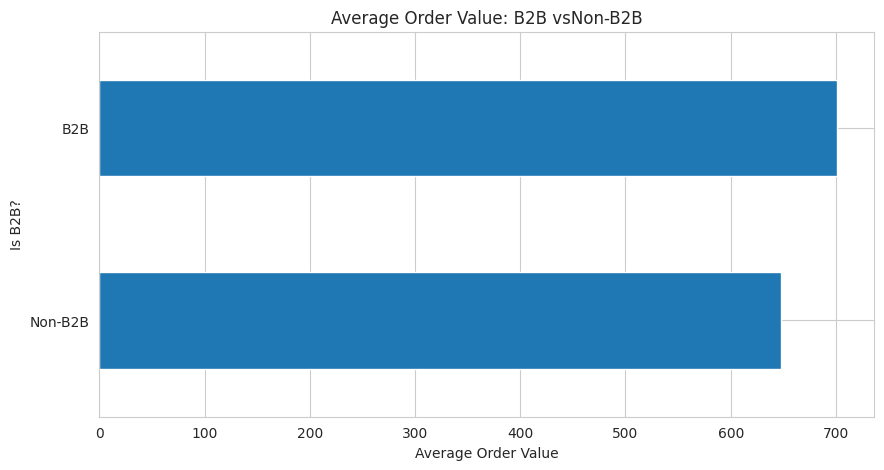

In [21]:
# B2B vs. Non-B2B Order Value Analysis
b2b_order_value = data.groupby('b2b')['amount'].mean()
plt.figure(figsize=(10, 5))
b2b_order_value.plot(kind='barh', title='Average Order Value: B2B vsNon-B2B')
plt.ylabel('Is B2B?')
plt.xlabel('Average Order Value')
plt.yticks([0, 1], ['Non-B2B', 'B2B'])
plt.show()

The horizontal bar chart visualizing the Average Order Value for B2B versus Non-B2B transactions shows a clear distinction between the two categories. B2B transactions have a notably higher average order value compared to Non-B2B transactions. This could imply that business customers tend to place larger orders, which might be due to bulk buying or a preference for higher-value transactions when businesses engage with one another. It's also possible that B2B transactions involve a different purchasing dynamic, such as negotiated contracts or recurring orders, which could naturally lead to higher values. The insight gained here could be leveraged to tailor marketing strategies, optimize inventory for B2B needs, or even streamline the sales process to cater more effectively to business clients.

# 4. PAYMENT BEHAVIOR ANALYSIS

In [22]:
# Inspecting unique values in 'promotion_ids'
print(data['promotion_ids'].unique())
# Counting the number of non-null 'promotion_ids'
print(data['promotion_ids'].notna().sum())

['No Promotion', 'Amazon PLCC Free-Financing Universal Merchant..., 'IN Core Free Shipping 2015/04/08 23-48-5-108', 'Amazon PLCC Free-Financing Universal Merchant..., 'Amazon PLCC Free-Financing Universal Merchant..., ..., 'Amazon PLCC Free-Financing Universal Merchant..., 'Amazon PLCC Free-Financing Universal Merchant..., 'Amazon PLCC Free-Financing Universal Merchant..., 'Amazon PLCC Free-Financing Universal Merchant..., 'Amazon PLCC Free-Financing Universal Merchant...]
Length: 5788
Categories (5788, object): ['Amazon PLCC Free-Financing Universal Merchant..., 'Amazon PLCC Free-Financing Universal Merchant..., 'Amazon PLCC Free-Financing Universal Merchant..., 'Amazon PLCC Free-Financing Universal Merchant..., ..., 'VPC-44571-41445561 Coupon', 'VPC-44571-44201687 Coupon', 'VPC-44571-44201770 Coupon', 'VPC-44571-44201853 Coupon']
128975


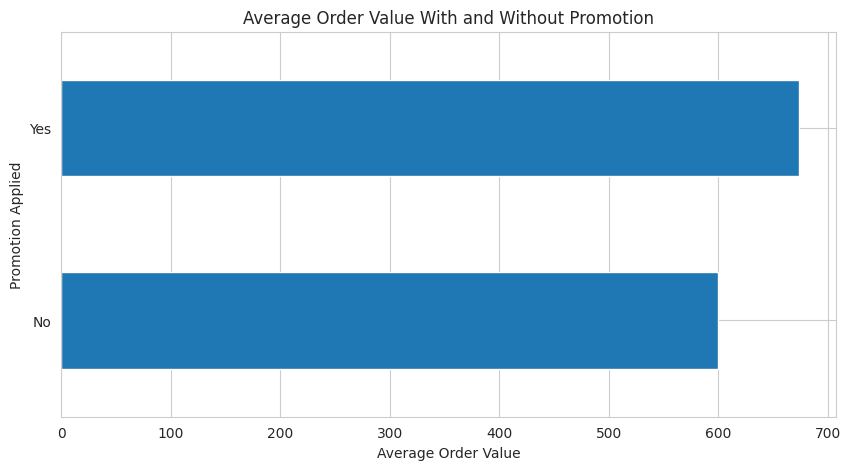

In [23]:
# Adjusting the logic to account for the explicit 'No Promotion' label
data['promotion_applied'] = data['promotion_ids'] != 'No Promotion'
# Now we can re-calculate the average order value with and without promotions applied
promotion_order_value = data.groupby('promotion_applied') ['amount'].mean()

plt.figure(figsize=(10, 5))
promotion_order_value.plot(kind='barh', title='Average Order Value With and Without Promotion')
plt.ylabel('Promotion Applied')
plt.xlabel('Average Order Value')
plt.yticks([0, 1], ['No', 'Yes'])
plt.show()

The horizontal bar chart demonstrates the comparison of average order values with and without the application of promotions. It is evident that **orders where a promotion was applied have a higher average value than those without promotions.** This could suggest that promotions are effective at encouraging customers to spend more per transaction, possibly by incentivizing larger purchases to meet promotion criteria or by increasing the perceived value of the deal.

# 5. CUSTOMER SEGMENTATION 

To perform customer segmentation based on purchasing behavior and demographics using the columns available in our dataset, we'll need to consider variables that can act as proxies for customer demographics and purchasing behavior. Since we don't have explicit customer demographic data like age or income, we'll use geographical location (ship_city, ship_state, ship_country), order size (qty), and order value (amount) as our segmentation bases.

In [24]:
# Grouping data by 'ship_country' and summarizing the total 'amount' 
country_sales = data.groupby('ship_country') ['amount'].sum().sort_values(ascending=False)
# Defining high volume and high value thresholds 
high_volume_threshold = data['qty'].quantile(0.75) # Top 25% of quantities ordered
high_value_threshold = data['amount'].quantile(0.75) # Top 25% of order amounts
# Creating new columns for high volume and high value
data['high_volume'] = data['qty'] >= high_volume_threshold
data['high_value'] = data['amount'] >= high_value_threshold

# Analyzing high volume vs. low volume segments
volume_segmentation = data.groupby('high_volume')['amount'].mean() # Analyzing high value vs. low value segments
value_segmentation = data.groupby('high_value')['qty'].mean()

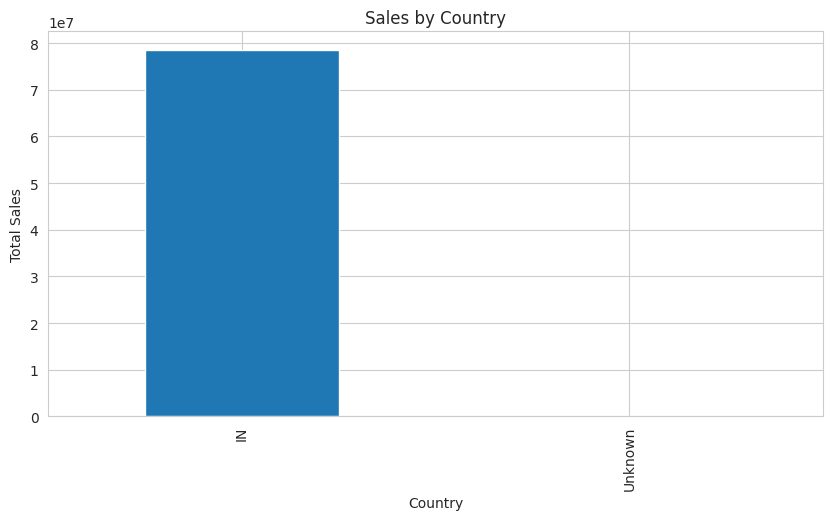

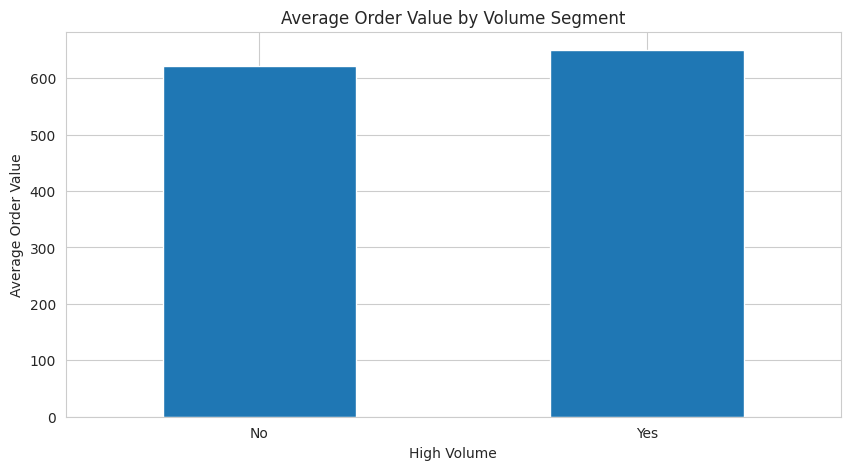

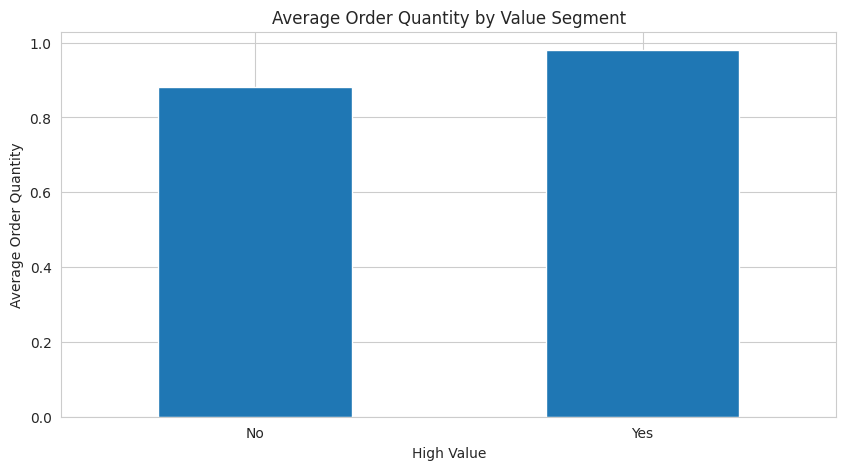

In [25]:
# Visualizing the segmentation
plt.figure(figsize=(10, 5))
country_sales.plot(kind='bar', title='Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.show()
plt.figure(figsize=(10, 5))
volume_segmentation.plot(kind='bar', title='Average Order Value by Volume Segment')
plt.xlabel('High Volume')
plt.ylabel('Average Order Value')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.show()
plt.figure(figsize=(10, 5))
value_segmentation.plot(kind='bar', title='Average Order Quantity by Value Segment')
plt.xlabel('High Value')
plt.ylabel('Average Order Quantity')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.show()

**Sales by Country**  
The 'Sales by Country' chart indicates a significant concentration of sales in one country, India. Probably because the data is taken from amazon.in

**Average Order Value by Volume Segment:**  
The 'Average Order Value by Volume Segment' chart compares the average order value of transactions classified as high volume to those that aren't. The chart shows that the average order value doesn't differ significantly between the two segments. This implies that customers are spending roughly the same amount on each order, regardless of the quantity of items purchased. This could indicate a consistent pricing strategy or a balance between the number of high-volume, low-cost item orders and low-volume, high-cost item orders.

**Average Order Quantity by Value Segment:**  
The 'Average Order Quantity by Value Segment' chart shows the average quantity of products ordered in high value versus low value segments. Interestingly, the chart shows very similar average order quantities for both high and low-value orders. This suggests that the value of orders may be more influenced by the type or price of the items being purchased rather than the quantity.

## 6. Customer Lifetime Value (CLV) Analysis

In [26]:
# Filtering the dataset for B2B transactions
b2b_data = data[data['b2b']]
# Calculating the average transaction amount per B2B customer
average_transaction_amount = b2b_data.groupby('order id') ['amount'].mean().reset_index() 
average_transaction_amount.columns = ['order id', 'average_transaction_amount']
# Calculating the frequency of repeat purchases per B2B customer
purchase_frequency = b2b_data.groupby('order id').size().reset_index() 
purchase_frequency.columns = ['order id', 'purchase_frequency']
# Merging the average transaction amount and purchase frequency dataframes on 'order id'
clv_data = pd.merge(average_transaction_amount, purchase_frequency, on='order id')
# Calculating CLV by multiplying the average transaction amount by the purchase frequency
clv_data['CLV'] = clv_data['average_transaction_amount'] * clv_data['purchase_frequency']

print(clv_data.head())

              order id  average_transaction_amount  purchase_frequency    CLV
0  171-0013919-1772325                       405.0                   1  405.0
1  171-0022483-5361108                       518.0                   1  518.0
2  171-0042571-2926720                       352.0                   1  352.0
3  171-0064169-5023569                       771.0                   1  771.0
4  171-0085140-6937160                       495.0                   1  495.0


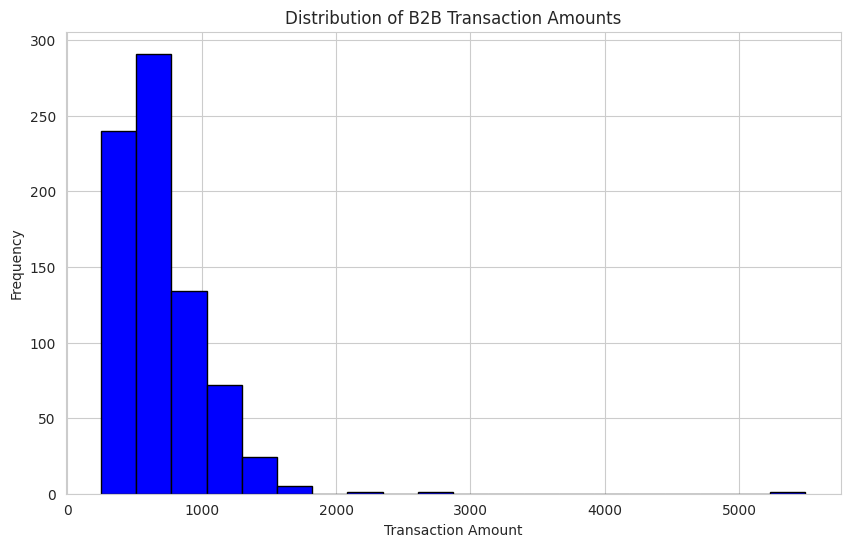

In [27]:
# Converting 'average_transaction_amount' to a list for plotting
transaction_amounts = clv_data['average_transaction_amount'].tolist()
# Creating a histogram of average transaction amounts
plt.figure(figsize=(10, 6))
plt.hist(transaction_amounts, bins=20, color='blue',
edgecolor='black')
plt.title('Distribution of B2B Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The histogram visualizes the distribution of B2B transaction amounts. Here's how to interpret it:

**Skewed Distribution:** The distribution of transaction amounts is right-skewed, meaning there are a higher number of transactions with lower amounts and fewer transactions with very high amounts.  
**Most Common Transaction Amounts:** The majority of transactions occur in the lower range of the spectrum (the tallest bars), suggesting that smaller transactions are more common among B2B customers.  
**High-Value Transactions:** There are relatively few high-value transactions, as indicated by the bars on the far right of the histogram that are close to the x-axis. This could represent occasional large purchases or orders from B2B clients.  
**Strategic Insights:** For business strategy, this suggests focusing on the most common transaction brackets for stable revenue while also nurturing the relationships that lead to the larger transactions.

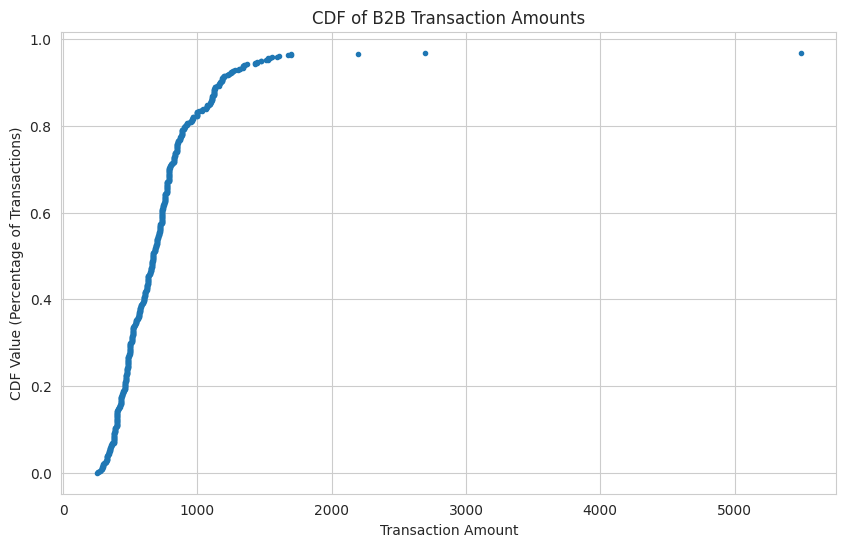

In [28]:
transaction_amounts = clv_data['average_transaction_amount'].tolist()
# Calculating the CDF values
transaction_amounts_sorted = np.sort(transaction_amounts)
cdf_values = np.arange(len(transaction_amounts_sorted)) / float(len(transaction_amounts_sorted) - 1)

plt.figure(figsize=(10, 6))
plt.plot(transaction_amounts_sorted, cdf_values, marker='.',linestyle='none')
plt.title('CDF of B2B Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('CDF Value (Percentage of Transactions)')
plt.grid(True)
plt.show()

The Cumulative Distribution Function (CDF) plot for B2B transaction amounts shows a curve that rises steeply at the beginning and then gradually levels off. Here's how to interpret this plot:

**Quick Ascent in the Beginning:** The CDF curve rises sharply at the lower end of the transaction amount axis, indicating that a significant portion of the transactions are of lower value. This implies that smaller transactions are very common in your B2B dealings.  

**Slow Progression to Full Percentage:** As the curve progresses towards the higher transaction values, it ascends more slowly, suggesting that there are fewer transactions with large amounts. This reflects that while high-value transactions do occur, they are less frequent.  

**Majority of Transactions Are Lower Value:** By looking at the point where the curve begins to flatten out (around the 80% mark), you can infer that the majority of the transactions (in this case, approximately 80%) are below that transaction amount.  

**High-Value Transactions Contribution:** The long tail extending to the right shows that there are a few transactions with very high amounts, though they are not many in number. These could be key accounts that contribute significantly to the revenue despite their lower frequency.

In [29]:
# Converting categorical columns to strings before concatenation to create a 'customer_id'
data['customer_id'] = data['ship_city'].astype(str) + '_' + data['ship_postal_code'].astype(str)
data['date'] = pd.to_datetime(data['date'])

# Now, we should group by 'customer_id' and 'date' to get the unique transactions per customer
repeat_purchase_frequency = data.groupby('customer_id') ['date'].nunique().reset_index()
# Renaming the columns for clarity
repeat_purchase_frequency.columns = ['customer_id','unique_purchase_dates']
# Sorting the DataFrame based on the 'unique_purchase_dates' to see customers with the most repeat purchases
repeat_purchase_frequency = repeat_purchase_frequency.sort_values('unique_purchase_dates', ascending=False)
print(repeat_purchase_frequency.head())

              customer_id  unique_purchase_dates
1620   BENGALURU_560100.0                     91
1596   BENGALURU_560076.0                     90
5344    GURUGRAM_122001.0                     90
11288      NOIDA_201301.0                     89
1557   BENGALURU_560037.0                     89


# 7. MARKET BASKET ANALYSIS

In [30]:
# Preparing the transactions data as a list of lists
transactions = data.groupby('order id')['sku'].apply(lambda x: x.tolist()).tolist()
patterns = pyfpgrowth.find_frequent_patterns(transactions, 2)
rules = pyfpgrowth.generate_association_rules(patterns, 0.2)
# Printing out the rules
for rule in rules:
    print(rule, "=>", rules[rule])

('BL107-M',) => (('J0348-SET-L',), 1.0)
('SET225-KR-NP-XXXL',) => (('SET289-KR-NP-XXXL',), 1.0)
('SET289-KR-NP-XXXL',) => (('SET225-KR-NP-XXXL',), 0.25)
('JNE3413-KR-XXXL',) => (('JNE3788-KR-XXXL',), 1.0)
('JNE3788-KR-XXXL',) => (('JNE3413-KR-XXXL',), 0.6666666666666666)
('JNE3899-KR-A-M',) => (('JNE3908-KR-M',), 1.0)
('JNE3908-KR-M',) => (('JNE3899-KR-A-M',), 0.4)
('NW036-ST-SR-XXL',) => (('NW020-ST-SR-XXL',), 0.6666666666666666)
('SAR135',) => (('SAR137',), 0.6666666666666666)
('SAR137',) => (('SAR135',), 0.3333333333333333)
('CH208-MUSTARD-L',) => (('JNE3701-KR-XL',), 0.6666666666666666)
('SET306-KR-PP-XS',) => (('SET308-KR-PP-XS',), 0.5)
('SET308-KR-PP-XS',) => (('SET306-KR-PP-XS',), 0.6666666666666666)
('J0077-SKD-XXXL',) => (('J0236-SKD-XXXL',), 0.6666666666666666)
('J0278-SET-XXL',) => (('SET268-KR-NP-XXL',), 0.6666666666666666)
('JNE3475-KR-K-XXL',) => (('JNE3431-KR-XXL',), 0.6666666666666666)
('JNE3425-KR-XXXL',) => (('JNE3376-KR-XXXL', 'JNE3463-KR-XXXL', 'JNE3468-KR-XXXL', 'J

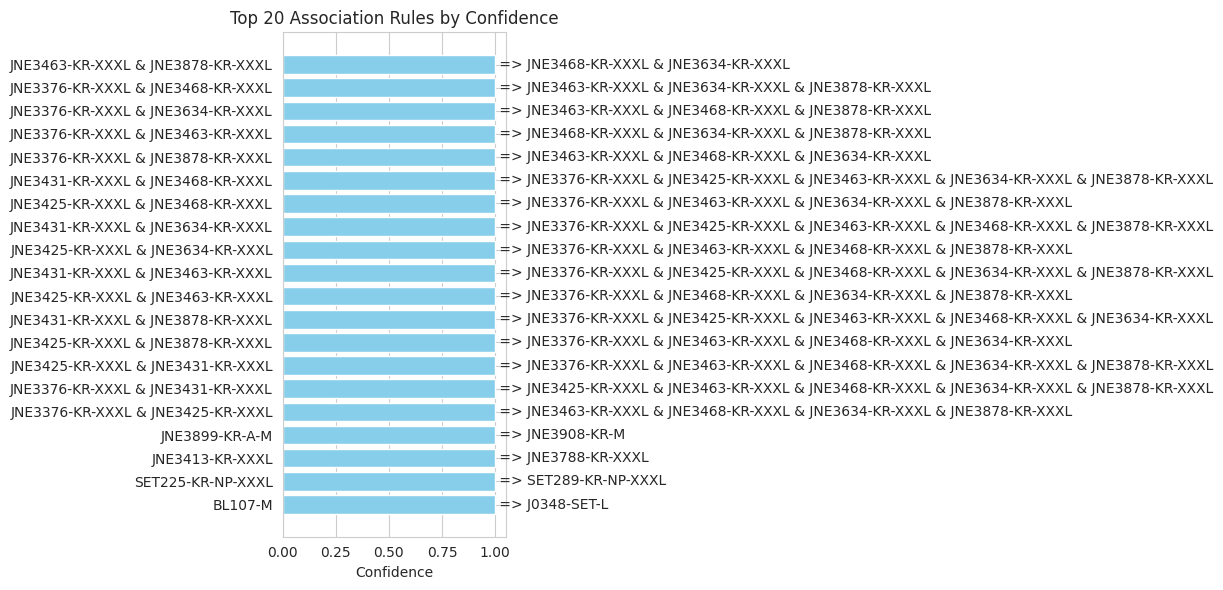

In [31]:
# Extracting rules and their confidence
rules_with_confidence = [(rule, rules[rule][0], rules[rule][1]) for rule in rules]
rules_with_confidence.sort(key=lambda x: x[2], reverse=True) 
top_rules = rules_with_confidence[:20]

# Separating the antecedents, consequents, and confidence for plotting 
antecedents = [' & '.join(rule[0]) for rule in top_rules] 
consequents = [' & '.join(rule[1]) for rule in top_rules] 

confidences = [rule[2] for rule in top_rules] 
fig, ax = plt.subplots(figsize=(12, 6)) 
ax.barh(antecedents, confidences, color='skyblue')

for i, (antecedent, consequent) in enumerate(zip(antecedents, consequents)):
    plt.text(confidences[i], i, f' => {consequent}', va='center')
    
ax.set_xlabel('Confidence')
ax.set_title('Top 20 Association Rules by Confidence')
plt.tight_layout()
plt.show()

# 8. CONCLUSION

The sales trends indicate **a seasonal or promotion-driven peak in April**, highlighting the impact of marketing or external factors on B2B sales performance. The following decline points to the potential end of these effects or a temporary market saturation. This suggests that while promotional activities can significantly boost sales, strategies should be developed to maintain a more consistent sales performance throughout the year.  

The **stability of Non-B2B sales** suggests a consistent consumer market, potentially less affected by the factors influencing B2B sales. This could be due to the different nature of B2C transactions, which may be more habitual or necessity-driven rather than opportunity-driven like B2B transactions.  

The **higher average order value in B2B transactions** underscores the larger scale of business purchases. It indicates opportunities for tailored B2B marketing strategies, inventory optimization to cater to bulk buying patterns, and sales process enhancements to better serve business clients.  

**Promotional strategies seem to be effective**, as indicated by the higher average order value of transactions with applied promotions. This effectiveness may be due to incentivizing larger purchases or enhancing the perceived value. The insight suggests that promotions could be strategically used to lift sales, especially during periods of expected decline.  

**The concentration of sales in India** might reflect the dataset's origin (amazon.in) and underscores the importance of local market understanding and tailoring strategies to regional specifics.  

The similar average order values across volume segments imply that **customers spend consistent amounts per order, irrespective of the quantity.** This may reflect effective pricing strategies that cater to various purchasing scales.  

The comparable average order quantities in high versus low-value segments suggest that **the order value is influenced more by the item types or prices rather than the quantity,** pointing towards a product mix that is well balanced between high-value and low-value items.  

The distribution of B2B transaction amounts, being right-skewed, indicates a **predominance of smaller transactions.** Strategic focus could be given to these smaller, more frequent transactions to drive steady revenue while also cultivating relationships that could lead to larger transactions.  

The CDF analysis further supports the prevalence of smaller transactions within B2B engagements, with **less frequent but significant high-value transactions.** The challenge and opportunity lie in nurturing key accounts that have the potential to contribute significantly to revenue despite their infrequency.  

In conclusion, the analysis underscores **the need for dynamic sales and marketing strategies** that are responsive to the identified patterns and trends. Efforts should be concentrated on maintaining sales momentum post-promotion peaks, leveraging promotions to boost higher- value transactions, and developing a balanced approach that caters to both high-frequency lower-value purchases and less frequent, high-value transactions. Additionally, the insights call for a region-specific focus to capitalize on the predominant market, with an eye towards expanding or diversifying as dictated by the sales data trends.